### Imports

In [213]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Directorio de imágenes

In [231]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

### Escalamiento y Preprocesado

In [232]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Escalar a [0, 1]
    rotation_range=30,
    width_shift_range=0.1,         
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    brightness_range=[0.8, 1.1], 
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(1./255)  # Escalar validation a [0, 1]
test_datagen = ImageDataGenerator(1./255)  # Escalar test a [0, 1]

In [237]:
# Generators
# Cargar imágenes de las carpetas y redimencionarlas

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (150, 150),
	batch_size = 8,  
	class_mode ='categorical', # 'categorical' para más de 2 clases a clasificar
	shuffle = True 
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2797 images belonging to 4 classes.
Found 279 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


<Figure size 640x480 with 0 Axes>

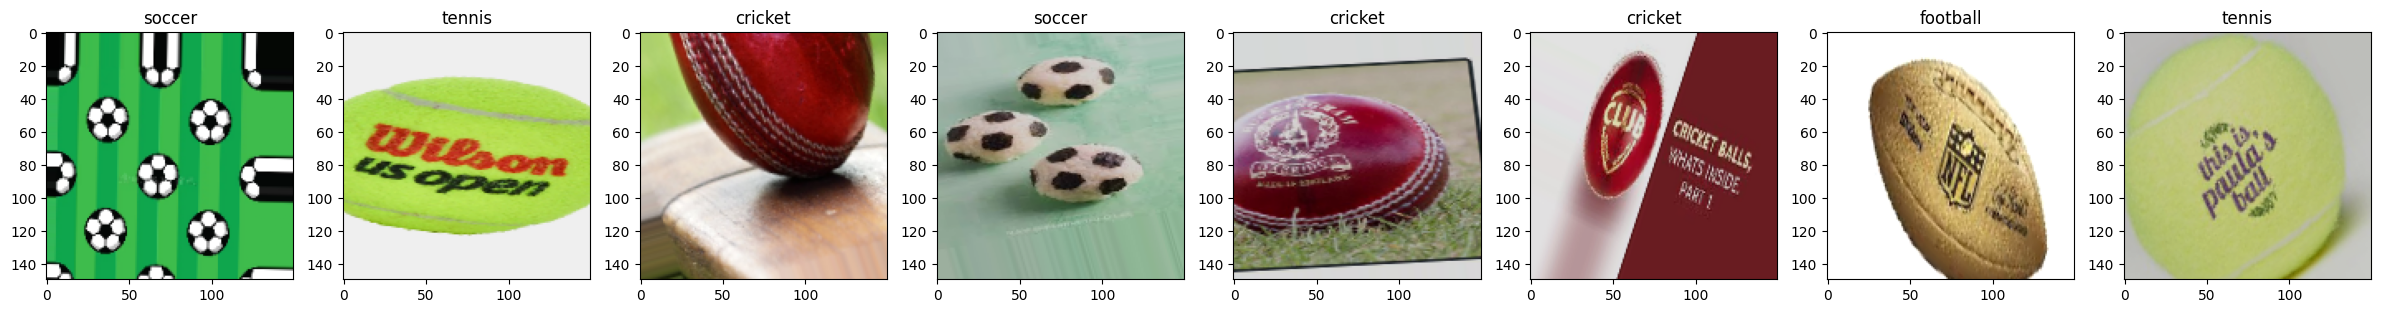

In [238]:
# Visualizar imágenes despúes de escalamiento y preprocesado
images, labels = train_generator[0]

class_names = list(train_generator.class_indices.keys()) # Obtener nombres de clases
label_indices = labels.argmax(axis=1)  # Convierte etiquetas a índices

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i])
    axarr[i].set_title(class_names[label_indices[i]], fontsize=12)

### Implementación del Modelo: Inspirado en la arquitectura ICNN-BNDOA

In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras import optimizers

def get_model_deep(input_shape, num_classes=4):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

In [259]:
num_classes = train_generator.num_classes

model = get_model_deep((150, 150, 3), num_classes=num_classes)
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_59 (Dropout)        (None, 36, 36, 32)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 34, 34, 64)      

In [262]:
def train_model_deep(model, train_generator, validation_generator):
    history = model.fit(train_generator, epochs=50, validation_data=validation_generator)
    return history
    
history = train_model_deep(model, train_generator, validation_generator)

Epoch 1/50
350/350 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.5552

/Users/fridabg/Desktop/AI-Model/venv/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


350/350 [==============================] - 24s 67ms/step - loss: 1.0657 - accuracy: 0.5552 - val_loss: 91.0308 - val_accuracy: 0.5735
Epoch 2/50
350/350 [==============================] - 27s 76ms/step - loss: 0.9586 - accuracy: 0.6296 - val_loss: 96.2790 - val_accuracy: 0.5914
Epoch 3/50
350/350 [==============================] - 23s 67ms/step - loss: 0.9095 - accuracy: 0.6564 - val_loss: 79.1140 - val_accuracy: 0.6093
Epoch 4/50
350/350 [==============================] - 25s 73ms/step - loss: 0.8568 - accuracy: 0.6814 - val_loss: 99.9437 - val_accuracy: 0.6272
Epoch 5/50
350/350 [==============================] - 23s 64ms/step - loss: 0.8366 - accuracy: 0.6850 - val_loss: 84.8220 - val_accuracy: 0.6380
Epoch 6/50
350/350 [==============================] - 23s 65ms/step - loss: 0.8031 - accuracy: 0.6929 - val_loss: 98.6885 - val_accuracy: 0.6272
Epoch 7/50
350/350 [==============================] - 23s 64ms/step - loss: 0.7783 - accuracy: 0.7079 - val_loss: 78.1827 - val_accuracy: 0.6

KeyboardInterrupt: 

In [249]:
# Guardar modelo
model.save('mi_modelo.h5')

In [263]:
from tensorflow.keras.models import load_model
model = load_model("mi_modelo.h5")

### Evaluación del Modelo

In [264]:
from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de métricas
print("Reporte:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))



9/9 [==============================] - 1s 128ms/step
Reporte:

              precision    recall  f1-score   support

     cricket       0.83      0.70      0.76        70
    football       0.93      0.80      0.86        70
      soccer       0.69      0.77      0.73        70
      tennis       0.75      0.89      0.81        70

    accuracy                           0.79       280
   macro avg       0.80      0.79      0.79       280
weighted avg       0.80      0.79      0.79       280



#### Gráfica Val vs. Tran

In [265]:
results = model.evaluate(test_generator)

print('\nTest loss:', results[0])
print('Test accuracy:', results[1])

/Users/fridabg/Desktop/AI-Model/venv/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


9/9 [==============================] - 1s 111ms/step - loss: 58.9223 - accuracy: 0.7893

Test loss: 58.922271728515625
Test accuracy: 0.7892857193946838


9/9 [==============================] - 1s 116ms/step - loss: 58.9223 - accuracy: 0.7893


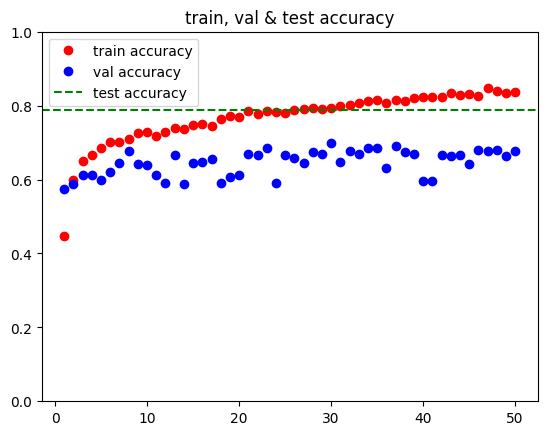

9/9 [==============================] - 1s 113ms/step - loss: 58.9223 - accuracy: 0.7893


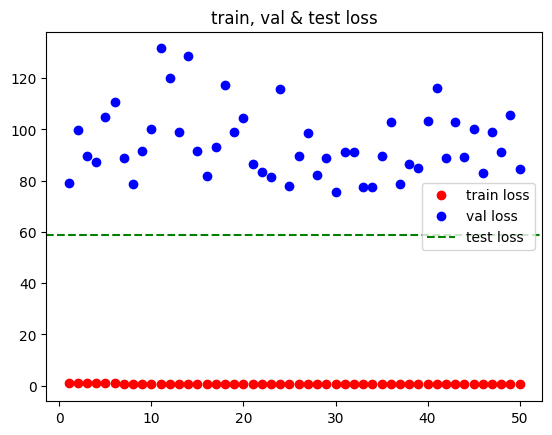

In [266]:
# Accuracy
test_loss, test_acc = model.evaluate(test_generator)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, 'ro', label='train accuracy')
plt.plot(epochs, val_accuracy, 'bo', label='val accuracy')
plt.axhline(y=test_acc, color='green', linestyle='--', label='test accuracy')
plt.title('train, val & test accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

results = model.evaluate(test_generator)
test_loss = results[0]  

plt.figure()
plt.plot(epochs, train_loss, 'ro', label='train loss')  
plt.plot(epochs, val_loss, 'bo', label='val loss')     
plt.axhline(y=test_loss, color='green', linestyle='--', label='test loss')

plt.title('train, val & test loss')
plt.legend()
plt.show()

9/9 [==============================] - 1s 118ms/step


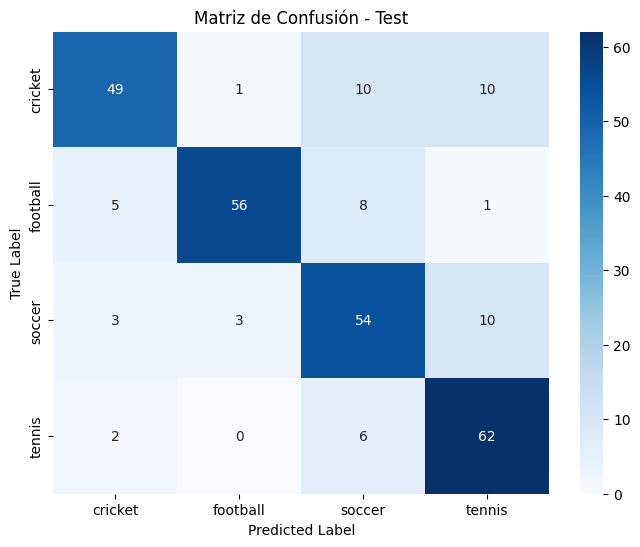

In [245]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas del generador
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

coparar desempeño del train y el desempeño del test

In [178]:
del train_datagen